# Project description
You're working as an analyst for Zuber, a new ride-sharing company that's launching in Chicago. 
- Your task is to find patterns in the available information. You want to understand passenger preferences and the impact of external factors on rides.
- Working with a database, you'll analyze data from competitors and test a hypothesis about the impact of weather on ride frequency.

# Step 1. Parsing data

In [2]:
# First we will open all packages that we will work with 
import warnings
warnings.filterwarnings('ignore')
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns
# Now we need to write code to parse the data on weather in Chicago in November 2017 from the website
URL = 'https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html'
reg = requests.get(URL)
soup = BeautifulSoup(reg.text, 'lxml')
weather_record = soup.find("table",attrs={"id": "weather_records"})
heading_table = []  # List where the names of the columns will be stored
#Let's create an empty list, heading_table, and save the column headings there. Then we'll use the find_all() method to find all the th elements. Using the text method, we'll extract the content and add it to heading_table:
for row in weather_record.find_all(
    'th'
):  
    heading_table.append(
        row.text
    )  # Add the content from the <th> tag to the heading_table list using append()
#Now we create an empty list called content, saving the table data there. We loop through all the rows by finding all tr elements.
# We  we're not interested in the first row of the table, which gives headings between <th> </th> tags. So we need to specify that it won't be added to the list by writing if not row.find_all('th') in the loop.
content = []  # list where the table data will be stored
for row in weather_record.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])
        
weather_records = pd.DataFrame(content, columns=heading_table)
weather_records.sample(5)
#We've turned the table from the website into something you already know fairly well: a DataFrame! Now we can work with it the same way you work with tables.

,Date and time,Temperature,Description
398,2017-11-17 14:00:00,274.780,mist
246,2017-11-11 06:00:00,269.550,sky is clear
363,2017-11-16 03:00:00,275.940,overcast clouds
486,2017-11-21 06:00:00,279.950,sky is clear
627,2017-11-27 03:00:00,280.320,sky is clear


- Conclusion: From this table, we can see that we have all the necessary information about the weather on each different days
Now that we have all our necessary information from the website we can start our exploratory data analysis

# Step 2. Exploratory data analysis
>2.1. Our first task is to find the number of taxi rides for each taxi company for November 15-16, 2017

``` mysql
 SELECT 
    c.company_name, COUNT(t.trip_id) as trips_amount 
FROM 
    cabs as c
LEFT JOIN 
    trips AS t USING(cab_id)
WHERE 
    t.start_ts::date BETWEEN '2017-11-15' AND '2017-11-16'
GROUP BY 
    c.company_name
ORDER BY 
    trips_amount DESC;
```

- Conclusion: Now when we found the total number of rides for each taxi company by November 15-16 2017 we can say that the most popular taxi Company was "Flash Cab". Let's move on 

> 2.2. In this step, we must fetch the number of rides for every taxi company whose name contains "Yellow" or "Blue" for November 1-7, 2017. 
``` mysql
SELECT 
    c.company_name, COUNT(t.trip_id) as trips_amount 
FROM 
    (SELECT *
     FROM
         cabs
     WHERE 
         company_name LIKE '%Yellow%' 
         OR
         company_name LIKE '%Blue%' 
    
    ) as c
LEFT JOIN 
    trips AS t USING(cab_id)
WHERE 
    t.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07' 
GROUP BY 
    c.company_name;

```

- Conclusion: From these SQL codes, we can say that we have only four companies Blue Diamond, Blue Ribbon Taxi Association Inc., Taxi Affiliation Service Yellow, and Yellow Cab which met the given conditions. 

> 2.3. For November 1-7, 2017, the most popular taxi companies were Flash Cab and Taxi Affiliation Services. Find the number of rides for these two companies and name the resulting variable trips_amount. Join the rides for all other companies in the group "Other." Group the data by taxi company names. Name the field with taxi company names company. Sort the result in descending order by trips_amount.
``` mysql
SELECT c.company, COUNT(t.trip_id) AS trips_amount
FROM (
    
    SELECT cab_id, vehicle_id,
    CASE
        WHEN company_name = 'Flash Cab' THEN 'Flash Cab'
        WHEN company_name = 'Taxi Affiliation Services' THEN 'Taxi Affiliation Services'
        ELSE 'Other'
    END AS company
    FROM
        cabs  ) AS c
  JOIN 
    trips AS t USING(cab_id)
WHERE 
    t.start_ts::date BETWEEN '2017-11-01' AND '2017-11-07' 
GROUP BY 
    c.company
ORDER BY
    trips_amount DESC;
```

- Conclusion: Here we found that the number of rides for Flash cab company is equal to 64084 and number of rides for Taxi Affiliation Services company is equal to 37583 and all other companies together have 335771 rides

> 2.4. Retrieve the identifiers of the O'Hare and Loop neighborhoods from the neighborhoods table.
``` mysql
SELECT *
FROM neighborhoods  
WHERE name ~* 'Hare|^Loop';
``` 

 - Conclusion: This data will need further steps when we will test our hypothese with Python.

> 2.5. For each hour, retrieve the weather condition records from the weather_records table. Using the CASE operator, break all hours into two groups: Bad if the description field contains the words rain or storm, and Good for others.

``` mysql
SELECT ts, 
        CASE
            WHEN description like  '%rain%'  THEN 'Bad'
            WHEN description like  '%storm%' THEN 'Bad'
            ELSE 'Good'
        END AS  weather_conditions
FROM 
    weather_records
GROUP BY 
    weather_conditions,
    ts
ORDER BY 
    ts;
```

- Conclusion: In this SQL code line, we assign a new column weather_conditions depending on weather conditions for each date.

> 2.6. Retrieve from the trips table all the rides that started in the Loop (pickup_location_id: 50) on a Saturday and ended at O'Hare (dropoff_location_id: 63). Get the weather conditions for each ride.
``` mysql
SELECT t.start_ts, wr.weather_conditions, t.duration_seconds
FROM
    trips as t
JOIN (SELECT ts, 
        CASE
            WHEN description like  '%rain%'  THEN 'Bad'
            WHEN description like  '%storm%' THEN 'Bad'
            ELSE 'Good'
        END AS  weather_conditions
FROM 
    weather_records
GROUP BY 
    weather_conditions,
    ts
ORDER BY 
    ts ) AS wr On wr.ts = t.start_ts
WHERE 
    pickup_location_id = 50 AND dropoff_location_id = 63 AND EXTRACT (DOW from t.start_ts) = 6
ORDER BY 
    t.trip_id

```


> Conclusion: After we have done all our work for getting all the necessary data from our website and grouping and joining all our working tables we can move on to the next step and making exploratory data analysis to the data we had retrieved in the previous tasks, we have a CSV files that contains all data what we made from the previous SQL codes, and now we can start working with them.

# Step 3. (Python)  Exploratory data analysis
Here we will work usually with the help of our panda's library etc. We have two datasets:
> First dataset '/datasets/project_sql_result_01.csv'It contains the following data:
- company_name: taxi company name
- trips_amount: the number of rides for each taxi company on November 15-16, 2017.
> Second dataset /datasets/project_sql_result_04.csv. It contains the following data:
- dropoff_location_name: Chicago neighborhoods where rides ended
- average_trips: the average number of rides that ended in each neighborhood in November 2017.


In [3]:
# import the file from first dataset and study the data it contains
company_inf = pd.read_csv('moved_project_sql_result_01.csv')
company_inf.info()
company_inf.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,company_name,trips_amount
8,Star North Management LLC,7455
13,Nova Taxi Affiliation Llc,3175
58,5062 - 34841 Sam Mestas,8
26,Gold Coast Taxi,428
33,Metro Jet Taxi A,146


In [4]:
#Checking for the missing values
company_inf.isnull().sum()

company_name    0
trips_amount    0
dtype: int64

In [5]:
#Great we dont have any missing value in our columns, let's get main information from our table
company_inf.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


- Conslusion: What we can see from the first table is that we have some problems with the Types of our data, but don't have any missing values, that is why I propose changing the type of our columns and moving to the next dataset

In [6]:
#let's change object type to string and int64 to int16 
company_inf['company_name'] = company_inf['company_name'].astype('string')
company_inf['trips_amount'] = company_inf['trips_amount'].astype('int16')
company_inf.info()
company_inf.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     string
 1   trips_amount  64 non-null     int16 
dtypes: int16(1), string(1)
memory usage: 768.0 bytes


,company_name,trips_amount
26,Gold Coast Taxi,428
47,4615 - 83503 Tyrone Henderson,21
61,5874 - 73628 Sergey Cab Corp.,5
49,5074 - 54002 Ahzmi Inc,16
48,3623 - 72222 Arrington Enterprises,20


> 3.2. After we preprocess our table we can find the top 10 companies with the highest number of trips like we did previously in our SQL code, and will add some visualizations

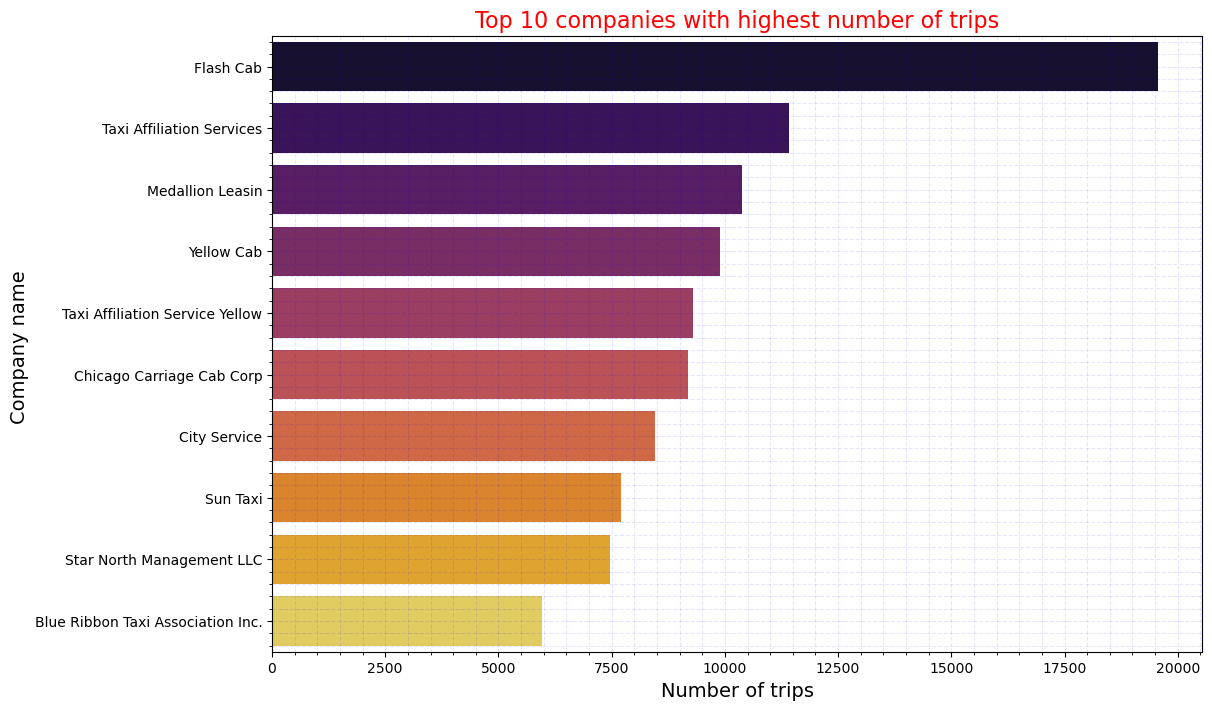

In [7]:
#prepare data: top companies with most trips on November 15-16, 2017
data=company_inf.sort_values('trips_amount', ascending=False)[:10]

#create fig object
plt.figure(figsize=(12,8))

#horizontal bar chart showing number of trips per company
sns.barplot(x='trips_amount', y='company_name', data=data, palette='inferno')

#customize the plot
plt.title('Top 10 companies with highest number of trips', fontsize=16, color='r')
plt.xlabel('Number of trips', fontsize=14, color='k')
plt.ylabel('Company name ', fontsize=14, color='k')
plt.grid(b=True, which='both', color='b', linestyle='--', alpha=0.1)
plt.minorticks_on()
plt.show()

- Now we can assume that all worked well we can import our Second dataset and start working with it. As we did in the previous code line, all the same, we will do this for the second dataset.

In [8]:
#Second dataset
trip_inf = pd.read_csv('moved_project_sql_result_04.csv')
trip_inf.info()
trip_inf.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


,dropoff_location_name,average_trips
17,Edgewater,583.300000
23,Rogers Park,299.033333
52,Little Village,33.800000
75,Calumet Heights,9.566667
67,Auburn Gresham,15.166667


In [9]:
trip_inf.isnull().sum()

dropoff_location_name    0
average_trips            0
dtype: int64

- I propose to round up our trip average values and convert them to int16 format that format will be easy to understand how many of each dropoff_location has average trips

In [10]:
#Method for rounding up values 
trip_inf['average_trips'] = trip_inf['average_trips'].round(0)
trip_inf.sample(5)

,dropoff_location_name,average_trips
27,Avondale,208.0
0,Loop,10727.0
90,Hegewisch,3.0
78,Gage Park,8.0
58,Englewood,25.0


In [11]:
#Now we can convert the type of columns to the necessary type
trip_inf['dropoff_location_name'] = trip_inf['dropoff_location_name'].astype('string')
trip_inf['average_trips'] = trip_inf['average_trips'].astype('int16')
trip_inf.info()
trip_inf.sample(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dropoff_location_name  94 non-null     string
 1   average_trips          94 non-null     int16 
dtypes: int16(1), string(1)
memory usage: 1.0 KB


,dropoff_location_name,average_trips
23,Rogers Park,299
48,Austin,44
82,South Deering,8
85,Montclare,6
17,Edgewater,583


In [12]:
#Checking for missing values
trip_inf.isnull().sum()

dropoff_location_name    0
average_trips            0
dtype: int64

In [13]:
#Extraction main information and move on to the next task
trip_inf.describe()

,average_trips
count,94.000000
mean,599.957447
std,1714.615082
min,2.000000
25%,14.000000
50%,52.000000
75%,298.750000
max,10727.000000


- Conclusion: By our second table, we can say that after rounding our average trip and converting column type to a necessary we can start analyzing it and making a conclusion, and from the last code line we can clearly say that most of our company has average trips amount in the range from 14 till 298. I propose to create a boxplot to consolidate our conclusions. 

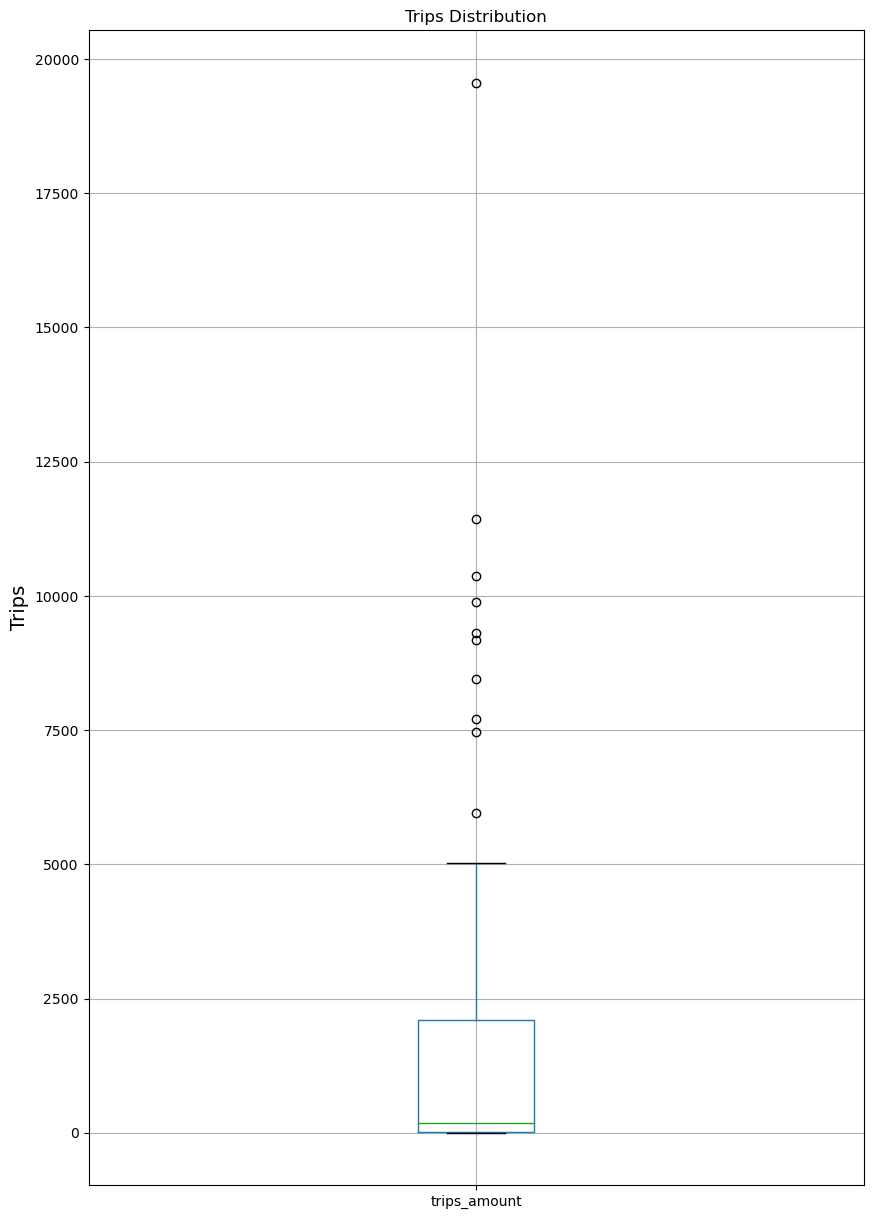

In [14]:
#Let's find out what kind of trips distribution we have from each company
company_inf.boxplot(figsize=(10,15))
plt.ylabel('Trips', fontsize=14)
plt.title('Trips Distribution');

- like we say in the previous conclusion most of our company has trips amount between 0 to around 100. But from this boxplot, we can't make any conclusion because we see that we have outliers that provide a negative impact on our final result, and this boxplot is just for visualization of our trip distributions. Now we can go further to the next step of our project.

> Step 3.2 identify the top 10 neighborhoods in terms of drop-offs

In [15]:
#Function for finding top 10 neighborhoods by drop-offs locations
top_10= trip_inf.sort_values('average_trips',ascending = False).head(10)
top_10

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
5,Lake View,2421
6,Grant Park,2069
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1260


- Conclusion: The most popular location of the taxi clients the "Loop" and "River North" regions. Let's add a little visualization to our table

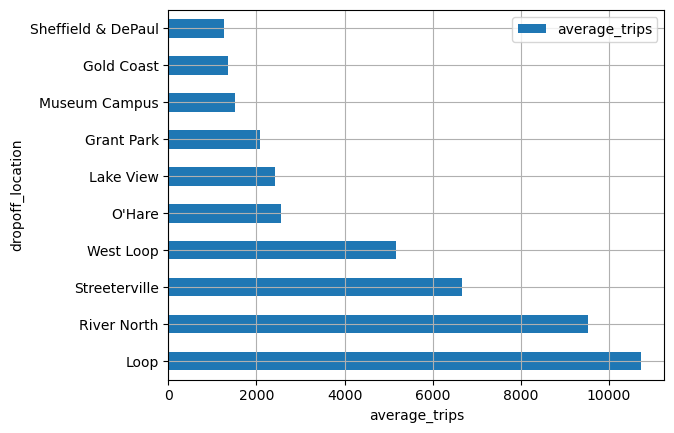

In [16]:
#Creating a bar graph to show what kind of drop of location prefer most of our clients
top_10.plot.barh(y='average_trips', x = 'dropoff_location_name',grid= True);
plt.ylabel('dropoff_location', fontsize=10)
plt.xlabel('average_trips', fontsize=10);

- Conclusion: The most popular location of the taxi clients the "Loop" and "River North".

# Step 4.Testing hypotheses (Python)

In this step we need to import additional data set from our previous (SQL) task "/datasets/project_sql_result_07.csv" — the result of the last query. It contains data on rides from the Loop to O'Hare International Airport. Here  we will test the hypothesis:
- "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays." 

- Ho: D(Good) = D(Bad) - means the duration of rides is not changed on rainy Saturdays.
- Ha: D(Good) != D(Bad) - means the average duration of rides is changed on rainy Saturdays.
> In order to test your hypothesis that the means of the two statistical populations are equal based on samples taken from them, we will apply the method "scipy.stats.ttest_ind".

In [17]:
#Load the data and gaining  main informations
test_data = pd.read_csv('moved_project_sql_result_07.csv')
test_data.info()
test_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


,start_ts,weather_conditions,duration_seconds
4,2017-11-11 07:00:00,Good,1440.0
843,2017-11-11 19:00:00,Good,1916.0
533,2017-11-18 16:00:00,Bad,3240.0
1064,2017-11-11 10:00:00,Good,1318.0
831,2017-11-25 11:00:00,Good,1680.0


In [18]:
#Convert columns type to a neccesary
test_data['start_ts'] = pd.to_datetime(test_data['start_ts'], format='%Y-%m-%d %H:%M')
test_data['weather_conditions'] = test_data['weather_conditions'].astype('string')
test_data['duration_seconds'] = test_data['duration_seconds'].astype('int16')
test_data.info()
test_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   string        
 2   duration_seconds    1068 non-null   int16         
dtypes: datetime64[ns](1), int16(1), string(1)
memory usage: 18.9 KB


,start_ts,weather_conditions,duration_seconds
434,2017-11-18 05:00:00,Good,1346
321,2017-11-04 06:00:00,Good,1496
807,2017-11-18 10:00:00,Bad,2083
429,2017-11-04 10:00:00,Good,2286
698,2017-11-11 10:00:00,Good,1920


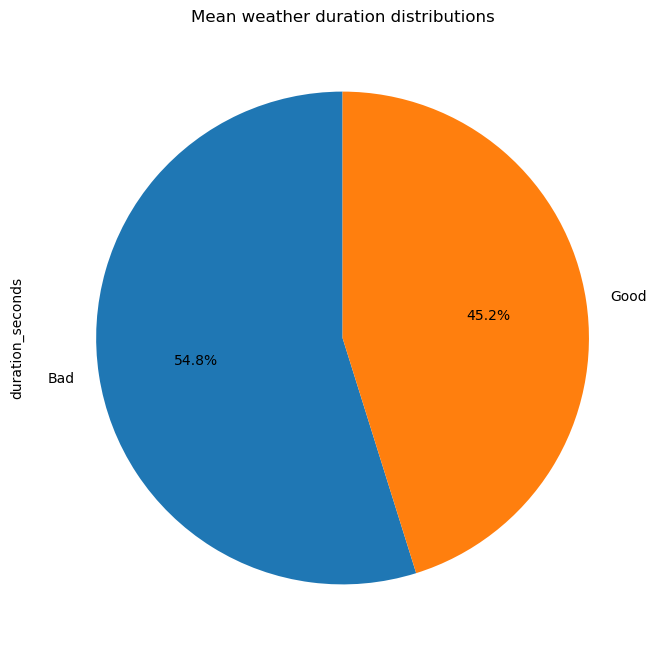

In [19]:

test_data.groupby(['weather_conditions'])['duration_seconds'].mean().plot(kind='pie',startangle=90,autopct='%1.1f%%',figsize=(10,8))
plt.title('Mean weather duration distributions');

- Conclusion: From this pie plot we can say that in bad weather the average trip duration is longer than in good condition weather, but let's move on to our hypothesis and see what we will have there.

In [20]:
#Checking if all is good with our data and if we do not need to make some operations with it 
test_data.isnull().sum()

start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64

In [21]:
# Let's create two samples grouping them by weather condition

wt_good = test_data.query('weather_conditions == "Good"')['duration_seconds']
wt_bad = test_data.query('weather_conditions == "Bad"')['duration_seconds']
alpha=0.05 #confidence level 95%

#test difference of mean of each plan
results = st.ttest_ind(wt_good, wt_bad)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis (The average duration of rides are significantly different on rainy Saturdays )!")
else:
    print("We can't reject the null hypothesis (The average duration of rides are not changes on rainy Saturdays )!")

p-value: 6.517970327099473e-12
We reject the null hypothesis (The average duration of rides are significantly different on rainy Saturdays )!


In [22]:
#Now let's calculate the average duraion of rides  for each weather conditions
print('The average duration of rides in Good weather condition:',round(np.mean(wt_good)),'seconds')
print('The average duration of rides in Bad weather condition:',round(np.mean(wt_bad)),'seconds')

The average duration of rides in Good weather condition: 2000 seconds
The average duration of rides in Bad weather condition: 2427 seconds


- Now let's show our graph distributions  and after we will make a conclusion

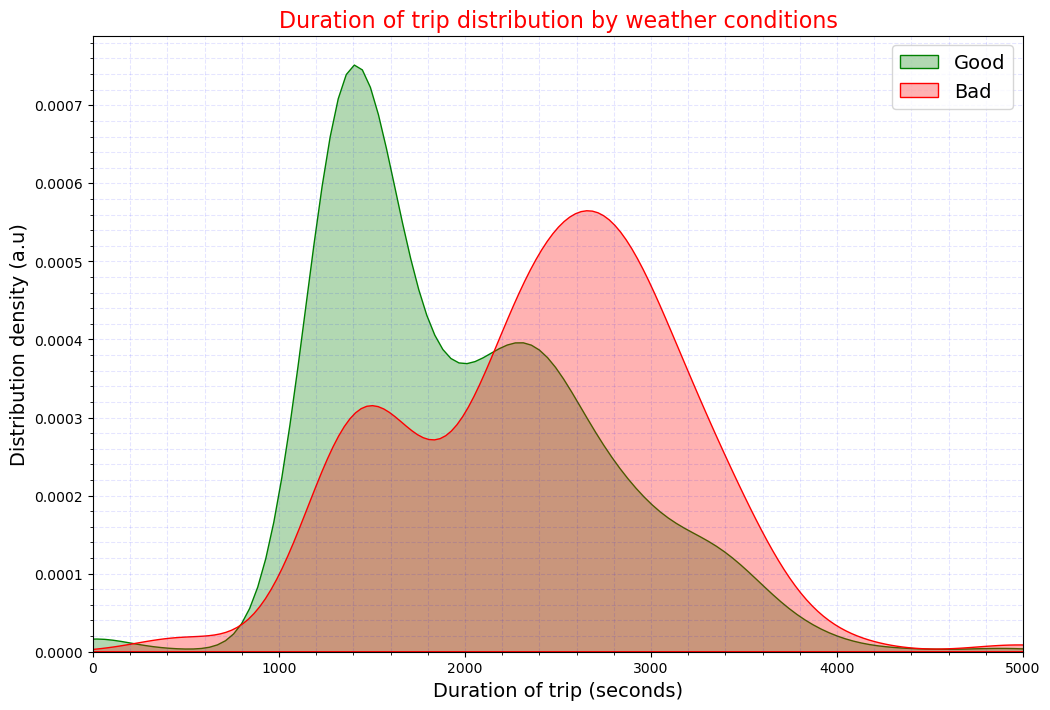

In [23]:
#Now let's show our distribution and by 
#create figure object
plt.figure(figsize=(12,8))

#plot distribution curves for each weather conditions
sns.distplot(wt_good, hist=False, kde_kws={'shade':True, 'color':'green', 'alpha':0.3}, label='Good')
sns.distplot(wt_bad, hist=False, kde_kws={'shade':True, 'color':'red', 'alpha':0.3}, label='Bad')

#customize the figure
plt.title('Duration of trip distribution by weather conditions', fontsize=16, color='r')
plt.xlabel('Duration of trip (seconds)', fontsize=14, color='k')
plt.ylabel('Distribution density (a.u)', fontsize=14, color='k')
plt.xlim(0, 5000) #there are some extreme values, we don't need to show them for now
plt.legend(fontsize=14)
plt.grid(b=True, which='both', color='b', linestyle='--', alpha=0.1)
plt.minorticks_on()
plt.show()

# Conclusion:
- After we tested our hypotheses and calculate the average duration in good and bad weather and created our density distribution graphic we can with 95% confidence say that weather conditions provide an impact on average trip durations, which in good weather conditions was significantly lower than average trip durations in bad weather conditions.